In [2]:
import numpy as np
import joblib
import torch.nn as nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
test = joblib.load("/kaggle/input/holedbach/jsb1-li-test.pkl")

X_train = train['0.8_holed']
Y_train = train['X']
training_data = list(zip(X_train.reshape(2604, 1, 128, 100), Y_train.reshape(2604, 1, 128, 100)))

X_test = test['0.8_holed']
Y_test = test['X']
testing_data = list(zip(X_test.reshape(792, 1, 128, 100), Y_test.reshape(792, 1, 128, 100)))

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True)

In [5]:
class BachBlock(nn.Module):
    def __init__(self, end=False):
        super(BachBlock, self).__init__()
        self.end = end
        self.DecBlock = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(16, 16), padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=(4, 4), padding='same'),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        if end:
            self.ec1 = nn.Conv2d(1, 16, kernel_size=(4, 4), padding='same')
            self.ecrelu = nn.ReLU()
            self.ec2 = nn.Conv2d(16, 1, kernel_size=(4, 4), padding='same')
            self.ecsig = nn.Sigmoid()


    def forward(self, x):
        x = self.DecBlock(x) + x
        if self.end:
            out = x
            x = self.ec1(x)
            x = self.ecrelu(x)
            x = self.ec2(x)
            x = self.ecsig(x) + out
        return x


class BachNet(nn.Module):
    def __init__(self, n_layers=1):
        super(BachNet, self).__init__()
        layers = []
        for layer in range(n_layers):
            end = layer == (n_layers - 1)
            layers.append(BachBlock(end=end))
            layers.append(nn.BatchNorm2d(1))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


model = BachNet(16) #  with 8 "heads" it performs as well as 16
if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model).cuda()

optim = Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Let's use 2 GPUs!
Number of parameters: 1118785


In [6]:
import gc 
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

report_gpu()

GPU:0
process       4168 uses      108.000 MB GPU memory


## Training Type 1

In [7]:
model.train()
for epoch in range(250): # faccio un solo batch ad epoca.
    _in, _out = next(iter(train_dataloader))
    _in, _out = _in.float().to(device), _out.float().to(device)
    pred = model(_in)

    loss = criterion(pred, _out)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if epoch % 10 == 0:
        print(f"{epoch}:  {loss.item()}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


0:  0.8702808022499084


KeyboardInterrupt: 

## Training Type 2

In [8]:
model.train()
for epoch in range(10): # faccio un solo batch ad epoca.
    for _in, _out in train_dataloader:
        _in, _out = _in.float().to(device), _out.float().to(device)
        pred = model(_in)
    
        loss = criterion(pred, _out)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    print(f"{epoch}:  {loss.item()}")

0:  0.2201939821243286
1:  0.054361023008823395
2:  0.020372750237584114
3:  0.01570018008351326
4:  0.015466549433767796
5:  0.015278331004083157


KeyboardInterrupt: 

## Visualizing Outputs on TEST

In [9]:
model.eval()
with torch.no_grad():
    t_in, t_out = next(iter(test_dataloader))
    t_in, t_out = t_in.float().to(device), t_out.float().to(device)
    pred = model(t_in)
    print(criterion(pred, t_out))

tensor(0.0150, device='cuda:0')


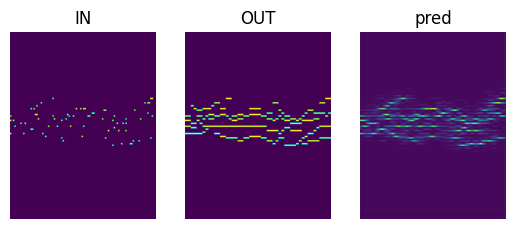

In [10]:
index = 2
imin = t_in[index].cpu().numpy()[0]
imout = t_out[index].cpu().numpy()[0]
impred = pred[index].cpu().numpy()[0]

plt.subplot(1, 3, 1) 
plt.imshow(imin)  
plt.axis('off')
plt.title("IN") 

plt.subplot(1, 3, 2) 
plt.imshow(imout)  
plt.axis('off')
plt.title("OUT") 

plt.subplot(1, 3, 3) 
plt.imshow(impred)  
plt.axis('off')
plt.title("pred") 


plt.show()

## Visualizing output on TRAIN

In [11]:
model.eval()
with torch.no_grad():
    _in, _out = next(iter(train_dataloader))
    _in, _out = _in.float().to(device), _out.float().to(device)
    pred_train = model(_in)
    print(criterion(pred_train, _out))

tensor(0.0151, device='cuda:0')


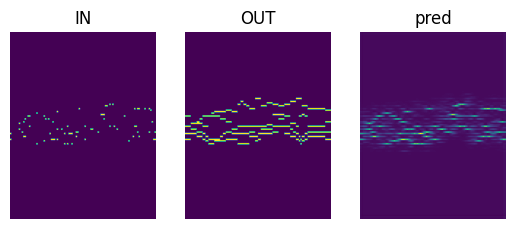

In [12]:

index = 5
imin = _in[index].cpu().numpy()[0]
imout = _out[index].cpu().numpy()[0]
impred = pred_train[index].cpu().numpy()[0]

plt.subplot(1, 3, 1) 
plt.imshow(imin)  
plt.axis('off')
plt.title("IN") 

plt.subplot(1, 3, 2) 
plt.imshow(imout)  
plt.axis('off')
plt.title("OUT") 

plt.subplot(1, 3, 3) 
plt.imshow(impred)  
plt.axis('off')
plt.title("pred") 


plt.show()

---

In [ ]:
joblib.dump(pred[5].cpu().numpy(), "pred5.pkl")

In [ ]:
torch.save(model.state_dict(), "model3.pt")

In [ ]:
model.load_state_dict(torch.load("/kaggle/input/model1/pytorch/default/1/model.pt", weights_only=True))
model.eval()